#*LSTM Using PyTorch*

https://gist.github.com/charlieoneill11/c18fda905a03508fd0626f0cf2a2775b

https://www.youtube.com/watch?v=6niqTuYFZLQ&t=3677s

https://www.youtube.com/watch?v=IV8--Y3evjw&t=3940s


In [1]:

!pip install yfinance

     |████████████████████████████████| 63 kB 1.0 MB/s 
     |████████████████████████████████| 6.4 MB 39.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

[*********************100%***********************]  1 of 1 completed


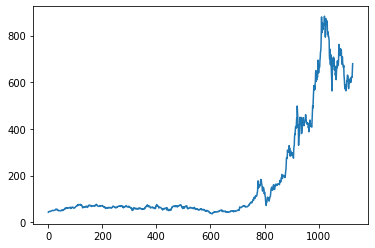

In [4]:

tick="TSLA"
start = '2016-12-31'
end = '2021-06-25'
news= yf.download(['TSLA'], start, end)['Close'].values
plt.plot(news, label = 'TSLA')

In [8]:
# this will be used for cross validation we can compare lagged values of the time series with our predictions

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(news.reshape(-1,1))

seq_length = 5
x, y = sliding_windows(training_data, seq_length)
bg=0.58
train_size = int(len(y) * bg)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [13]:
class LSTM(nn.Module):

    def __init__(self, hidden_size):
      # crreare a super class as in docs
        super(LSTM, self).__init__()
        input_size = 1

        num_layers = 1
        num_classes = 1 


        # let us declare the parameters
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        self.cnn=nn.Conv1d(1,751, kernel_size=1,stride=1,padding =1)
        self.bn1=nn.BatchNorm1d(3)
        self.maxpool1=nn.MaxPool1d(kernel_size=2,stride=2,padding=1)
        self.dropout=nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
    
    
        # Propagate input through LSTM

        ula, (h_0,c_0) = self.lstm(x, (h_0, c_0))
        ula2,(h_out,_)= self.lstm2(h_0,(h_1,c_1))
        h_out = h_out.view(-1, self.hidden_size)

        #out =self.fc(h_out)
        #out=self.cnn(out)
        #out=self.bn1(out)
        #out=self.maxpool1(out)
       # out=self.dropout(out)
        out =self.fc(h_out)

      #  
        
        
        
        return out


        

In [14]:

num_epochs = 10000
learning_rate = 0.001

input_size = 1

num_layers = 1
num_classes = 1
hidden_size = 6
lstm = LSTM(hidden_size)

criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    #cross validate
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


RuntimeError: ignored

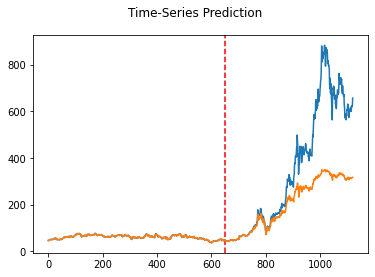

In [12]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()